In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
# imports

import pandas as pd
import numpy as np
import collections
from datetime import datetime

import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

# import statsmodels.formula.api as sm #for linear regression: sm.ols

# from pandas_datareader import DataReader

import geopandas as gpd
import plotly.express as px

%matplotlib inline
# activate plot theme



# Project One

# What Attributes Determine a Yelp rating?

## 1. Introduction

This analysis contains data from the *Yelp Dataset* published by Yelp, and accessed through Kaggle. The Y variable studied is the Yelp rating restaurants receieve, as a result of five X variables analyzed in this report: the number of reviews a restaurant recieves, the city the resataurant is located, the number of checkins a restaurant has recorded, and the category value that a restaurant is associated with.


The number of reviews a restaurant recieves is of interest because it could be the case that more popular restaurants recieve more reviews, but the ratings may reflect otherwise. Whether more reviews indicates higher-rated restaurants is of interest. The city a restaurant is located is examined to determine whether the geographical location of a restaurant is a determinate of the kind of rating a restaurant may recieve. The number of checkins a restaurant has recieved is studied to determine whether eagerness to report a checkin would correlate with higher ratings. The category items that a restaurant is associated with is analyzed to determine whether certain cuisines or keywords are predictive of the type of rating a restaurant may recieve.

## 2. Data Cleaning/Loading

In [3]:
# datasets
df_business = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business.csv'))
df_tip = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_tip.csv'))
df_attributes = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_attributes.csv'))
df_hours = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_business_hours.csv'))
df_checkin = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_checkin.csv'))
df_user = pd.DataFrame(pd.read_csv('/Users/vickychan/Desktop/ECO225Project/Data/yelp_user.csv'))

### Data Cleaning for Users

In [4]:
df2_user = df_user.copy()
df2_user = df2_user.drop(columns=['friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos', 'compliment_hot'])
df2_user.head(10)

,user_id,name,review_count,yelping_since,average_stars
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,3.70
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,2.00
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,4.67
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,4.67
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,3.45
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,4.78
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,5.00
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,1.00
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,4.29
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,5.00


A clean copy of user data with columns removed because most users have no data recorded in those columns. The 'user_id' column contains the unique ID for each Yelp reeviewer, and contains the information of the other columns in the df2_users dataframe. The 'name' column contains the name the reviewer has indicated, the 'review_count' column indicates the total number of reviews the reviewer has written, the 'yelping_since' column indicates the date the Yelp user registered, and the 'average_stars' column indicates the average star rating the reviewer typically writes. 

### Data Cleaning for Businesses

In [5]:
df2_business = df_business.copy()
id_drops = []
for i in df2_business.index:
    if "Restaurants" not in df2_business['categories'][i] or df2_business['is_open'][i] != 1:
        id_drops.append(df2_business['business_id'][i])
    else:
        df2_business['categories'][i] = df_business['categories'][i].split(";")

df2_business = df2_business[df2_business.business_id.isin(id_drops) == False]

/var/folders/1n/1z07zvls361__r72g5fj81t00000gn/T/ipykernel_45787/3240343098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_business['categories'][i] = df_business['categories'][i].split(";")


In [6]:
for i in df2_business['city'].index:
    df2_business['city'][i] = df2_business['city'][i].capitalize()
df2_business.head(10)

/var/folders/1n/1z07zvls361__r72g5fj81t00000gn/T/ipykernel_45787/1459413544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_business['city'][i] = df2_business['city'][i].capitalize()


,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga falls,OH,44221,41.119535,-81.475690,3.5,116,1,"[American (New), Nightlife, Bars, Sandwiches, ..."
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,"[Italian, Restaurants]"
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Uptown,"""600 E 4th St""",Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,"[Restaurants, American (Traditional)]"
19,Gu-xs3NIQTj3Mj2xYoN2aw,"""Maxim Bakery & Restaurant""",NaN,"""9665 Bayview Avenue, Unit 1-4""",Richmond hill,ON,L4C 9V4,43.867565,-79.412662,3.5,34,1,"[French, Food, Bakeries, Restaurants]"
25,1K4qrnfyzKzGgJPBEcJaNQ,"""Chula Taberna Mexicana""",Leslieville,"""1058 Gerrard Street E""",Toronto,ON,M4M 3A6,43.669256,-79.335902,3.5,39,1,"[Tiki Bars, Nightlife, Mexican, Restaurants, B..."
28,Dj0S-Oe4ytRJzMGUPgYUkw,"""Panera Bread""",NaN,"""38295 Chestnut Ridge Rd""",Elyria,OH,44035,41.343078,-82.067140,2.0,4,1,"[Soup, Salad, Sandwiches, Restaurants]"
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""",NaN,"""2777 Steeles Avenue W""",Toronto,ON,M3J 3K5,43.781816,-79.490433,5.0,3,1,"[Restaurants, Breakfast & Brunch]"
33,FXHfcFVEfI1vVngW2gVOpw,"""Bampot House of Tea & Board Games""",NaN,"""201 Harbord Street""",Toronto,ON,M5S 1H6,43.661582,-79.408878,4.0,55,1,"[Coffee & Tea, Restaurants, Food, Mediterranea..."
40,tRVx2c89coruPRwYhGTcTw,"""Yuzu""",NaN,"""13603 Madison Ave""",Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,"[Nightlife, Izakaya, Comfort Food, Cocktail Ba..."
45,rDMptJYWtnMhpQu_rRXHng,"""McDonald's""",NaN,"""719 E Thunderbird Rd""",Phoenix,AZ,85022,33.607070,-112.064382,1.0,10,1,"[Fast Food, Burgers, Restaurants]"


A clean copy of the business data which filters for businesses that are restaurants and capitalizes all the city names. The first column, 'business_id' contains the unique ID's for the restaurants on Yelp. The other columns in the df_business dataframe contain the specific details for each restaurant. The 'name' column specifies the name of the restaurant. The 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', and 'longitutde' columns all specify the location of the respective restaurants. The 'stars' column specifies the star rating the restaurants receive on Yelp, the 'review_count' column indicates the total amount of reviews the restaurants have recieved, and the 'categories' column contains the keywords these restaurants are labelled with. 

### Data Cleaning for Tips

In [7]:
df2_tip = df_tip.copy()
df2_business_tip = df2_business[['business_id', 'name', 'stars']]
df2_tip = df2_tip[df2_tip.business_id.isin(id_drops) == False]
df2_tip = pd.merge(df2_business_tip, df2_tip, on='business_id').drop(['business_id', 'likes'], axis = 1)

df2_tip.head(10)

,name,stars,text,date,user_id
0,"""Brick House Tavern + Tap""",3.5,People are giving this place 1 star because of...,2013-02-19,8v1rpTH0d8YjjGWA892l1Q
1,"""Brick House Tavern + Tap""",3.5,"Excellent selection of beers on tap, many scre...",2013-05-11,y_RCzjU-K_KrMBko3mMhsg
2,"""Brick House Tavern + Tap""",3.5,Great event held by yelp!! Will be back!!,2012-10-15,3OhkexT0E78zylIH426EOg
3,"""Brick House Tavern + Tap""",3.5,I love this place. They always take good care ...,2012-01-18,RgTByLRNRTJNmeWgp6Kg4Q
4,"""Brick House Tavern + Tap""",3.5,Chop Steak was surprisingly good. Love love lo...,2011-09-29,RgTByLRNRTJNmeWgp6Kg4Q
5,"""Brick House Tavern + Tap""",3.5,Good beer and even better food,2016-02-18,EAfLAFYv46w2SCvgN_m_VQ
6,"""Brick House Tavern + Tap""",3.5,Go!!,2014-08-06,yTIQesfMFpf038iEFx1keQ
7,"""Brick House Tavern + Tap""",3.5,"Try the Mac and Cheese, it's the best I have e...",2012-11-26,EaCzl3GqLvbq-IO3yOrm6g
8,"""Brick House Tavern + Tap""",3.5,So many beers on tap and huge snack menu. Week...,2017-09-29,4s_zxWFUqW6-TKYMPYUOiQ
9,"""Brick House Tavern + Tap""",3.5,"Beautiful women, great food and spirits.",2012-03-04,Er7va1rRXiQVVcz2LOwXKg


This dataframe illustrates a clean copy of the data in the 'yelp_tip' csv file where the business names are merged with the a user's review based on the 'business_id' of restaurants. The 'name' column specifies which restaurant has received the specific review. The 'stars' column indicates the number of stars that a user has given to a restaurant, the 'text' column contains the review comments that a user left, 'date' contains when a review was written and the 'user_id' column attaches the unique user's ID to the review they have written. 

### Data Cleaning for Attributes

In [8]:
df2_attributes = df_attributes.copy()
df2_business_attributes = df2_business[['business_id', 'name', 'stars']]
df2_attributes = df2_attributes[df2_attributes.business_id.isin(id_drops) == False]
df2_attributes = df2_attributes.drop(columns=['AcceptsInsurance', 'ByAppointmentOnly', 'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican', 'HairSpecializesIn_curly', 'HairSpecializesIn_perms', 'HairSpecializesIn_kids', 'HairSpecializesIn_extensions', 'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms', 'Music_dj', 'Music_karaoke', 'GoodForDancing', 'Smoking', 'DogsAllowed', 'BusinessAcceptsBitcoin', 'AgesAllowed' ])
df2_attributes = pd.merge(df2_business_attributes, df2_attributes, on='business_id').drop(['business_id'], axis = 1)
df2_attributes.head(10)

,name,stars,BusinessAcceptsCreditCards,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,RestaurantsPriceRange2,GoodForKids,...,BYOB,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,RestaurantsCounterService
0,"""Brick House Tavern + Tap""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,"""Messina""",4.0,Na,Na,False,False,False,False,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,"""Showmars Government Center""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,"""Maxim Bakery & Restaurant""",3.5,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,"""Chula Taberna Mexicana""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
5,"""Panera Bread""",2.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
6,"""Sunnyside Grill""",5.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
7,"""Bampot House of Tea & Board Games""",4.0,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
8,"""Yuzu""",3.5,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
9,"""McDonald's""",1.0,Na,Na,False,False,False,True,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


This dataframe reflects a clean copy of data from the 'yelp_attributes' csv file by removing attributes that are unrelated to restaurants, and only contains restaurant businesses. Additionally, the restaurant name and star rating from the 'yelp_businesses' dataframe is merged with the 'yelp_attributes' data based on the unique 'business_id' that is associated with each business. The 'name' column indcates the name of the restaurants, and 'stars' contains the number of Yelp stars that a restaurant has recieved. The columns 'BusinessAcceptsCreditCards', 'BusinessParking_garage', 'BusinessParking_street', 'BusinessParking_validated', 'BusinessParking_lot', 'BusinessParking_valet', and 'GoodForKids' provide information on the payment method available, the convenience of parking, and whether the environment is suitable for children. The columns 'BYOB', 'Corkage', 'DietaryRestrictions_dairy-free', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_vegan','DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_soy-free', 'DietaryRestrictions_vegetarian', and 'RestaurantsCounterService' contain information pertaining to the dietary accessibility of a restaurant.  

### Data Cleaning for Business Hours

In [9]:
df2_hours = df_hours.copy()
df2_business_hours = df2_business[['business_id', 'name', 'stars']]
df2_hours = df2_hours[df2_hours.business_id.isin(id_drops) == False]

# clean restaurants with no business hours any day
no_hours = []
for i in df2_hours.index:
    if df2_hours['monday'][i] == df2_hours['tuesday'][i] == df2_hours['wednesday'][i] == df2_hours['thursday'][i] == df2_hours['friday'][i] == df2_hours['saturday'][i] == df2_hours['sunday'][i] == 'None':
        no_hours.append(i)

df2_hours.drop(no_hours, axis=0, inplace=True)

#clean data for opening and closing hours 
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

for col in days:
    df2_hours[[col+'_open', col+'_close']] = df2_hours[col].apply(lambda x: pd.Series(str(x).split('-')))

df2_hours = df2_hours.drop(days, axis=1)
df2_hours = pd.merge(df2_business_hours, df2_hours, on='business_id').drop(['business_id'], axis = 1)
df2_hours.head(10)


,name,stars,monday_open,monday_close,tuesday_open,tuesday_close,wednesday_open,wednesday_close,thursday_open,thursday_close,friday_open,friday_close,saturday_open,saturday_close,sunday_open,sunday_close
0,"""Brick House Tavern + Tap""",3.5,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,1:0,11:0,2:0,11:0,0:0
1,"""Messina""",4.0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,18:0,0:0,None,NaN
2,"""Showmars Government Center""",3.5,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,None,NaN,None,NaN
3,"""Maxim Bakery & Restaurant""",3.5,11:30,22:0,11:30,22:0,11:30,22:0,11:30,22:0,11:30,23:0,11:0,23:0,11:0,22:0
4,"""Chula Taberna Mexicana""",3.5,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,11:30,2:0,10:30,2:0,10:30,2:0
5,"""Panera Bread""",2.0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,21:0,6:30,22:0,7:0,22:0,7:0,20:0
6,"""Sunnyside Grill""",5.0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0,7:0,15:0
7,"""Bampot House of Tea & Board Games""",4.0,17:0,23:0,11:0,23:0,11:0,23:0,11:0,23:0,12:0,1:30,12:0,1:30,12:0,23:0
8,"""Yuzu""",3.5,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,12:0,2:0,11:0,2:0,None,NaN
9,"""Charr An American Burger Bar""",3.0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,22:0,11:0,23:0,11:0,23:0,11:0,21:0


This dataframe includes a clean copy of the business hours data where the restaurant opening and closing times for each day are sperated into individual columns. Restaurant names and their rating are matched with their business hours based on their 'business_id'. The 'name' column includes the names of the restaurants, and the 'stars' column specifies the rating the restaurant has recieved on Yelp. The columns 'monday_open', 'tuesday_open', 'wednesday_open', 'thursday_open', 'friday_open', 'saturday_open', and 'sunday_open' indicate the time that the restaurants open on each day of the week. The columns 'monday_close', 'tuesday_close', 'wednesday_close', 'thursday_close',  'friday_close', 'saturday_close', and 'sunday_close' contain the time that the restaurants close on each day of the week. 

### Data Cleaning for Yelp Checkins

In [10]:
df2_checkin = df_checkin.copy()
df2_checkin = df2_checkin[df2_checkin.business_id.isin(id_drops) == False].drop(columns = ['weekday', 'hour']).groupby('business_id')['checkins'].sum()

df2_business_checkin = df2_business[['business_id', 'name', 'stars']]

df2_checkin = pd.merge(df2_checkin, df2_business_checkin, on='business_id')
df2_checkin = df2_checkin.drop(['business_id'], axis = 1)[['name', 'checkins', 'stars']]

df2_checkin.head(10)

,name,checkins,stars
0,"""John's Chinese BBQ Restaurant""",139,3.0
1,"""Delmonico Steakhouse""",2568,4.0
2,"""Sunnyside Grill""",89,3.5
3,"""The Bar At Bermuda & St. Rose""",490,3.5
4,"""Mm Mm Pizza""",20,4.0
5,"""Happy Moose Bar and Grill""",89,3.5
6,"""Hungry Howie's Pizza""",93,3.0
7,"""Denny's""",60,2.0
8,"""Keung Kee Restaurant""",148,3.5
9,"""Pio Pio""",672,4.0


This dataframe contains a clean copy of data from the 'yelp_checkins' csv file, and analyzes restaurants by their total number of checkins and the star rating they have recieved. The 'name' column includes the name of the restaurant, the 'checkins' column indicates the total number of checkins a restaurant has received on Yelp, and the 'stars' column contains the star rating a restaurant has received. 

## 3. Summary Statistic Tables

In [11]:
def get_summary_statistic(df, column):
    result = {column: [], 'total_restaurants': [], 'sum_stars' : [], 'average_stars': []}
    # access the cells
    for i in df.index:
        # check for list condition
        if type(df[column][i]) == list:
            for j in df[column][i]:
                if j not in result[column]:
                    result[column].append(j)
                    result['total_restaurants'].append(1)
                    result['sum_stars'].append(df['stars'][i])
                else:
                    index = result[column].index(j)
                    result['total_restaurants'][index] += 1
                    result['sum_stars'][index] += df["stars"][i]
        else:
            if df[column][i] not in result[column]:
                result[column].append(df[column][i])
                result['total_restaurants'].append(1)
                result['sum_stars'].append(df["stars"][i])
            else:
                index = result[column].index(df[column][i])
                result['total_restaurants'][index] += 1
                result['sum_stars'][index] += df["stars"][i]

    for i in result[column]:
        avg = result['sum_stars'][result[column].index(i)]/result['total_restaurants'][result[column].index(i)]
        result['average_stars'].append(round(avg, 2))

    dataframe = pd.DataFrame(result).sort_values(by='total_restaurants', ascending=False)
    return dataframe

The function above produces a summary statistics data frame which passes in a data frame and a column name to be analyzed. The 'X' variable consists of items in the given column and the 'Y' variable is the average star rating for restaurants that fall under a category in the column. The summary statistic provides the "total_restaurants", which reflects how many restaurants fall under a category item, "sum stars", which reflects the total sum of stars restaurants in the category receive, and "average_stars", which reflects the average star rating a restaurant in that category receives. 

### Summary statistics of reviews and Yelp stars

In [12]:
review_summary_statistic = get_summary_statistic(df2_business, 'review_count').drop(columns=['sum_stars']).sort_values(by='review_count')

review_summary_statistic

,review_count,total_restaurants,average_stars
6,3,3217,3.31
5,4,2125,3.37
1,5,1764,3.34
13,6,1557,3.31
2,7,1380,3.34
...,...,...,...
427,4774,1,4.00
903,4869,1,4.50
699,5950,1,3.50
850,7009,1,4.00


This summary statistic indicates the average star rating for restaurants with a certain number of reviews. The 'review_count' column indicates the number of reviews that restaurants receive and the 'average_stars' column indicates the average star rating that restaurants with that specific number of reviews receive. 

### Summary statistics of Category types and Yelp stars

In [13]:
category_summary_statistic = get_summary_statistic(df2_business, 'categories').drop(columns=['sum_stars', 'total_restaurants']).drop(6).drop(11).head(15)
category_summary_statistic

,categories,average_stars
9,Food,3.73
1,Nightlife,3.55
26,Fast Food,2.85
2,Bars,3.55
3,Sandwiches,3.46
36,Pizza,3.35
4,American (Traditional),3.36
5,Burgers,3.00
15,Breakfast & Brunch,3.59
7,Italian,3.54


This summary statistic reflects a category restaurants indicate in their Yelp descriptions and the average star rating for restaurants that fall under the respective category. The 'categories' column indicates the specified category, and the 'average_stars' column indicates the average number of stars restaurants in that category receive. 

### Summary Statistics of the Correlation Between the City a Restaurant is located and its Yelp Rating

In [14]:
city_summary_statistic = get_summary_statistic(df2_business, 'city').drop(columns=['sum_stars']).drop(columns=['total_restaurants'])
interested = ['Toronto', 'Las vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Montreal', 'Edinburgh', 'Stuttgart']
city_summary_statistic = city_summary_statistic[city_summary_statistic.city.isin(interested) == True]
city_summary_statistic

,city,average_stars
4,Toronto,3.44
9,Las vegas,3.44
7,Phoenix,3.42
2,Charlotte,3.39
12,Edinburgh,3.83
16,Scottsdale,3.66
1,Stuttgart,3.74
10,Montreal,3.57


This summary statistic describes the average star rating for restaurants in their respective cities. The 'city' column lists the top 8 cities that restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these cities receive. 

### Summary Statistic of Correlation Between the State a Restaurant is Located and its Yelp Rating

In [15]:
top_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'BW':[], 'EDH':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in top_state_summary_statistic['state'].index:
    if top_state_summary_statistic['state'][i] in new_frame:
        new_frame[top_state_summary_statistic['state'][i]] = top_state_summary_statistic['average_stars'][i]
top_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
top_state_summary_statistic.columns = ['state', 'average_stars']
top_state_summary_statistic

,state,average_stars
0,AZ,3.41
1,BW,3.74
2,EDH,3.82
3,IL,3.34
4,NC,3.38
5,NV,3.43
6,OH,3.43
7,ON,3.40
8,PA,3.50
9,QC,3.68


This summary statistic describes the average star rating for restaurants in their respective states for the top 10 states with the most restaurants reported in the dataset. The 'state' column lists the states where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these states receive.

### Summary Statistic of Correlation Between a State in the United States a Restaurant is Located and its Yelp Rating

This summary statistic describes the average star rating for restaurants located in the United States The 'state' column lists the states where restaurant businesses are located and the 'average_stars' column represents the average star rating restaurants in these states receive.

In [16]:
us_state_summary_statistic = get_summary_statistic(df2_business, 'state')
new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}

for i in us_state_summary_statistic['state'].index:
    if us_state_summary_statistic['state'][i] in new_frame:
        new_frame[us_state_summary_statistic['state'][i]] = us_state_summary_statistic['average_stars'][i]
us_state_summary_statistic =  pd.DataFrame(list(new_frame.items()))
us_state_summary_statistic.columns = ['state', 'average_stars']
us_state_summary_statistic

,state,average_stars
0,AZ,3.41
1,PA,3.50
2,SC,3.24
3,IL,3.34
4,NC,3.38
5,NV,3.43
6,OH,3.43
7,WI,3.47


### Summary Statistic of Correlation Between Checkins and Yelp Stars

In [17]:
checkin_summary = get_summary_statistic(df2_checkin, "checkins").drop(columns=['sum_stars', 'total_restaurants'])
checkin_summary.head(10)


,checkins,average_stars
87,1,3.45
18,2,3.44
9,3,3.43
23,4,3.42
39,5,3.38
19,6,3.44
78,7,3.39
26,8,3.41
40,9,3.45
34,10,3.39


This summary of statistics reflects the total number of check-ins restaurants have received and the average Yelp star rating they typically receive. 

The 'checkins' column represents the number of check-ins that restaurants have received and the 'average_stars' column represents the average star rating restaurants with that number of check-ins typically receive. 

### Summary Statistic of Correlation between a US state and the Number of Restaurants and the Average Rating for Those Restaurants

In [28]:
us_num_summary_statistic = get_summary_statistic(df2_business, 'state')
total = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'PA':[], 'WI':[]}
reviews = {'AZ':[0], 'PA':[0], 'SC':[0], 'IL':[0], 'NC':[0], 'NV':[0], 'OH':[0], 'PA':[0], 'WI':[0]}

for i in us_num_summary_statistic['state'].index:
    if us_num_summary_statistic['state'][i] in total:
        total[us_num_summary_statistic['state'][i]] = us_num_summary_statistic['total_restaurants'][i]
us_num_summary_statistic =  pd.DataFrame(list(total.items()))
us_num_summary_statistic.columns = ['state', 'total_restaurants']

for i in df2_business['state'].index:
    if df2_business['state'][i] in reviews:
        reviews[df2_business['state'][i]] += df2_business['review_count'][i].astype(int)

state_reviews =  pd.DataFrame(list(reviews.items()))
state_reviews.columns = ['state', 'review_total']

for i in state_reviews.index:
    state_reviews['review_total'][i] = state_reviews['review_total'][i][0]

us_states_1 = pd.merge(us_num_summary_statistic, us_state_summary_statistic, on ='state')
us_states = pd.merge(us_states_1, state_reviews, on ='state')
us_states

,state,total_restaurants,average_stars,review_total
0,AZ,7367,3.41,788960
1,PA,2759,3.50,138271
2,SC,140,3.24,5495
3,IL,453,3.34,20491
4,NC,2924,3.38,177494
5,NV,4851,3.43,892223
6,OH,3762,3.43,149629
7,WI,1110,3.47,64367


## 4. Plots, Histograms, Figures

### Line Plot for Number of Reviews and Average Restaurant Rating

Text(0, 0.5, 'Rating')

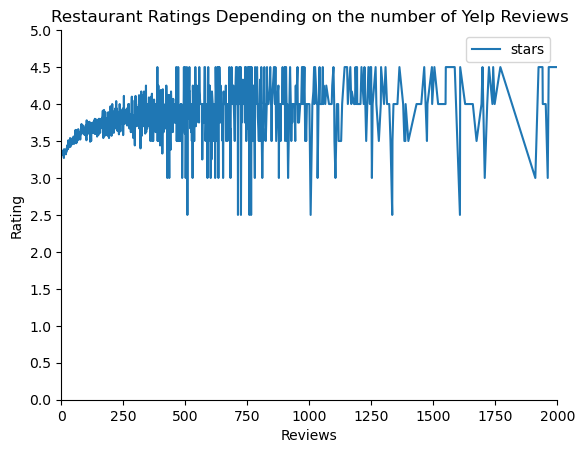

In [19]:
review = []
stars = []
for i in review_summary_statistic.index:
    review.append(review_summary_statistic['review_count'][i])
    stars.append(review_summary_statistic['average_stars'][i])
df = pd.DataFrame({
   'review':review,
   'stars': stars})
lines = df.plot.line(x ='review', y='stars')
lines.set_xlim(0, 2000)
lines.set_ylim(0, 5)
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
lines.spines['right'].set_visible(False)
lines.spines['top'].set_visible(False)
lines.set_title("Restaurant Ratings Depending on the number of Yelp Reviews")
lines.set_xlabel('Reviews')
lines.set_ylabel('Rating')

This line graph illustrates the number of reviews restaurants recieve and the average rating that restaurants with the specified reviews recieve. From this graph, it can be observed that when restaurnats have less reviews of around under 250, they tend to recieve ratings of about 3.5 Yelp stars, on average. However, when restaurants have more ratings, the average rating can vary a lot more, and where the range encompasses ratings around 2.5 to 4.5. Observations can be drawn from this data that when more reviews are given, the true quality of the restauarant may be more likely to be reflected. 

### Bar Chart for Restaurant Categories and the Average Restaurant Rating

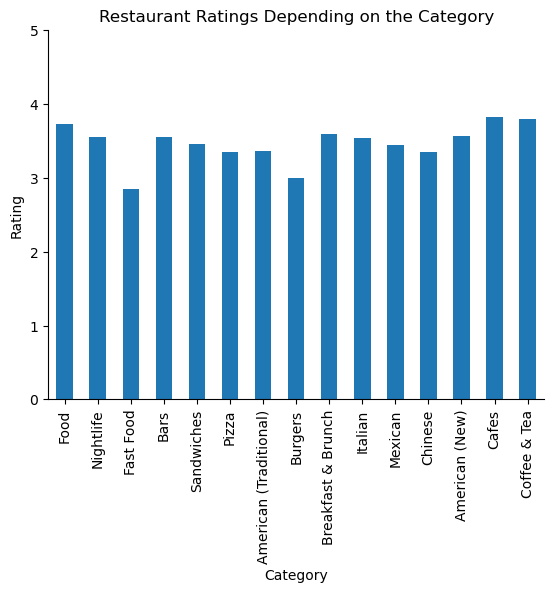

In [20]:
categories = []
stars = []
for i in category_summary_statistic.index:
    categories.append(category_summary_statistic['categories'][i])
    stars.append(category_summary_statistic['average_stars'][i])
df = pd.DataFrame({'category': categories, 'stars': stars})

ax = df.plot.bar(x='category', y='stars', legend=False)
ax.set_xlabel('Category')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the Category")
plt.yticks([0, 1, 2, 3, 4, 5])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This box plot illustrates the top 15 categories that restaurants are tagged with and the average rating that restaurants in those categories receive. This is an correlation to observe because it can predict the average rating a restaurant may recieve if they fall under this category, or if they add this category to their restaurant description. Additionally, it can reflect the quality of the restaurants under these categories. For example, restaurants that fall under the 'Fast Food' and 'Burger'category on average recieve less ratings than the other most common retaurant categories which could lead to a potential analysis of whether fast food restuarant quality is on average worse than restaurants in the other categories. 

### Scatterplot for the  Rating Restaurants Recieve Depending on the Number of Checkins

Text(0.5, 1.0, 'Restaurant Ratings Depending on Checkins')

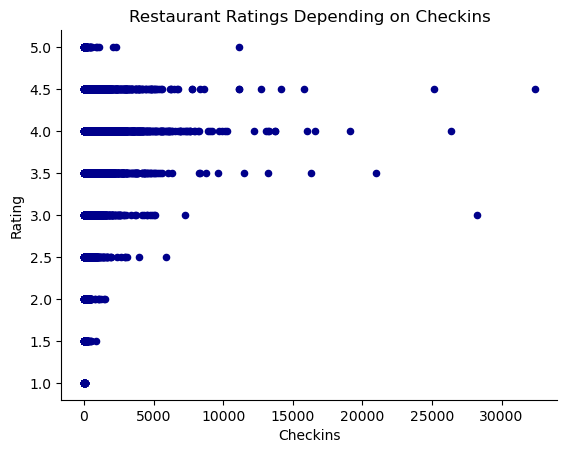

In [21]:
ax = df2_checkin.plot.scatter(x='checkins', y='stars', c='DarkBlue')

ax.set_xlabel('Checkins')
ax.set_ylabel('Rating')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Restaurant Ratings Depending on Checkins")

This scatterplot illustrates the spread of how the number of check-ins restaurants receive correlates with ratings. From this plot, it can be observed that it is more densely packed around a rating of 4 which suggests that people are more likely to check in on Yelp for restaurants when it is considered a 4-star restaurant. These results also reflect how Yelper's may be more likely to interact with a restaurant when they consider it to be around a 4-star rating.

### Boxplot for Average Restaurant Rating Based on the City

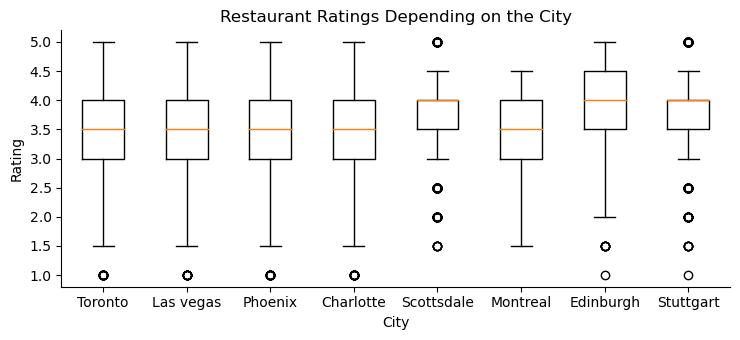

In [22]:
new_frame = {'Toronto':[], 'Las vegas':[], 'Phoenix':[], 'Charlotte':[], 'Scottsdale':[], 'Montreal':[], 'Edinburgh':[], 'Stuttgart':[]}
df2_city = df2_business[['city','stars']]

for i in df2_city.index:
    if df2_city['city'][i] in new_frame:
        new_frame[df2_city['city'][i]].append(df2_city['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('City')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the City")
plt.show()

This boxplot represents the average rating of restaurants based on the city they are located in. Results from this plot can lead to further conclusions of restaurant quality depending on the city, or possibly how Yelpers review restaurants in those cities. For restaurants, this data could be important so that they can expect, on average, the kind of review they may receive. For Yelpers, this data could be important for knowing the quality of restaurants they can expect when in a city. The boxplot's findings show how cities in North America tend to receive Yelp ratings of around 3.5 stars, while cities in Europe tend to receive higher Yelp ratings of around 4.0 stars. These results may lead to further elaboration on whether Yelpers in North America and Europe rate restaurants differently, or whether restaurant quality is on average better in Europe. 

### Boxplot for Average Restaurant Rating Based on the State

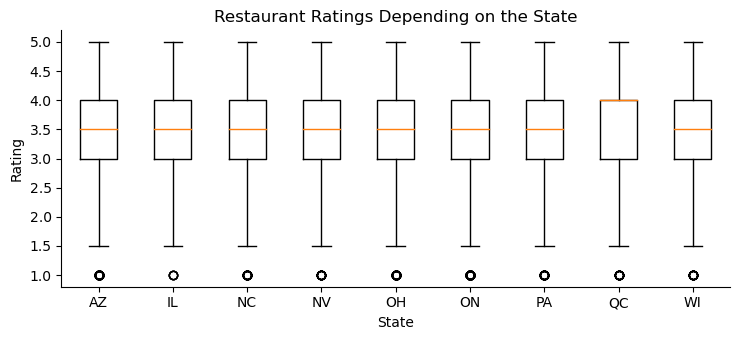

In [23]:
df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'QC':[], 'WI':[]}

for i in df2_state.index:
    if df2_state['state'][i] in new_frame:
        new_frame[df2_state['state'][i]].append(df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State")
plt.show()


This boxplot illustrates the average restaurant ratings of restaurants based on the state they are in. This information could be useful for restaurants to see whether the state location of their restaurant is a factor in the type of rating that they would expect to receive. These states are displayed to represent the top 9 states reported with the highest number of restaurants reported. From this graph, it can be observed that QC is reported to have the highest restaurant ratings, on average. The other states all tend to have average restaurant ratings of around 3.5 stars. Interstingly, QC is the only non-American state, and this observation could lead to two possible conclusions. Yelpers in the United States may on average review restaurants lower than Yelpers in Canada, or the quality of restaurants in Canada may on average be better. The circles on the graph represent outlier restaurants in their respective states.

### Boxplot for Average Restaurant Rating Based on the State Located in the United States

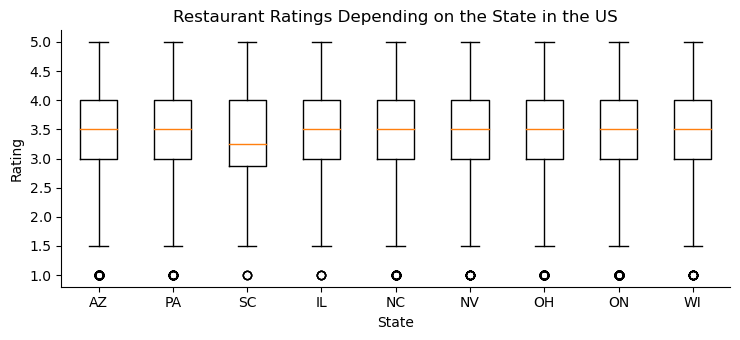

In [24]:
us_df2_state = df2_business[['state','stars']]

new_frame = {'AZ':[], 'PA':[], 'SC':[], 'IL':[], 'NC':[], 'NV':[], 'OH':[], 'ON':[], 'PA':[], 'WI':[]}
for i in us_df2_state.index:
    if us_df2_state['state'][i] in new_frame:
        new_frame[us_df2_state['state'][i]].append(us_df2_state['stars'][i])

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = new_frame
fig, ax = plt.subplots()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
ax.set_xlabel('State')
ax.set_ylabel('Rating')
ax.set_title("Restaurant Ratings Depending on the State in the US")
plt.show()

# Project Two

## The Message


The main concern of this paper is to determine whether there is a correlation between the state restaurants are located in the United States and the number of restaurants in that state on the Yelp rating that they receive. This question can lead to futher inquires of whether Yelp reviewers in different States rate restaurants on different scales, or if restaurants in different states serve at varying quality levels as well as the effect of competition of restaurants on the rating. 

A visualization to explore this question involves a scatter plot with the number of restaurants on the x-axis and the Yelp rating on the y-axis where the points will indicate where restaurants in those states fall. 

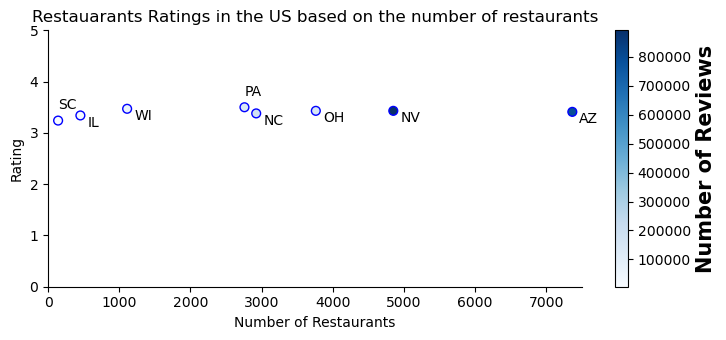

In [93]:
import seaborn as sns

plt.scatter(us_states.total_restaurants, us_states.average_stars, s=40, c=us_states.review_total, cmap='Blues', edgecolors='blue')

for (i, row) in us_states.iterrows():
    state = row.state
    if state in ['SC', 'PA']:
        offset = (0, 8)
    else:
        offset = (5,-8)
    plt.annotate(
        state, xy=(row["total_restaurants"], row["average_stars"]), xytext=offset, textcoords='offset points', fontsize=10
    )

plt.xlim([0, 7500])
plt.ylim([0, 5])
plt.xlabel('Number of Restaurants')
plt.ylabel('Rating')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Restauarants Ratings in the US based on the number of restaurants')
# plt.colorbar()
plt.colorbar().set_label(label='Number of Reviews',size=15,weight='bold')

# plt.colorbar(), set_label(label='Number of Reviews')
plt.show()


Text(0.5, 1.0, 'Restauarants Ratings in the US based on the number of restaurants')

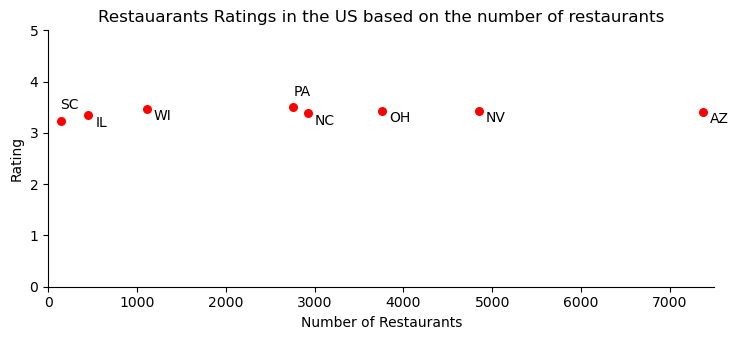

In [32]:
ax = us_states.plot.scatter(x = 'total_restaurants', y = 'average_stars', s = 30, c = 'red')

for (i, row) in us_states.iterrows():
    state = row.state
    if state in ['SC', 'PA']:
        offset = (0, 8)
    else:
        offset = (5,-8)
    ax.annotate(
        state, xy=(row["total_restaurants"], row["average_stars"]), xytext=offset, textcoords='offset points', fontsize=10
    )
# f, ax = plt.subplots()
# points = ax.scatter(x = 'total_restaurants', y = , c=z, s=50, cmap="plasma")
# f.colorbar(points)


ax.set_xlim(0, 7500)
ax.set_ylim(0, 5)
ax.set_xlabel('Number of Restaurants')
ax.set_ylabel('Rating')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Restauarants Ratings in the US based on the number of restaurants')


## Maps and Interpretations

Outcome Variable: create a denisty map for North America to show the spread of ratings in each state 
This density map reflects the Yelp rating that restaurants recieve in each state across North America. 
Independent Variable: Create a denisty map for North America to show the denisty of restaurants in each state
This density map reflects the number of restaurants in each state across North America

Extra Challenge: Create a map layering maps 1 + 2 where the density map is the first layer and the star ratings is a 3D portion 


Connection between the two maps
Between the two maps, a correlation between the density of restaurants and their Yelp star ratings can be made. 

### Worldmap of Restaurants

Text(0.5, 1.0, 'Worldmap of Yelp Restaurants')

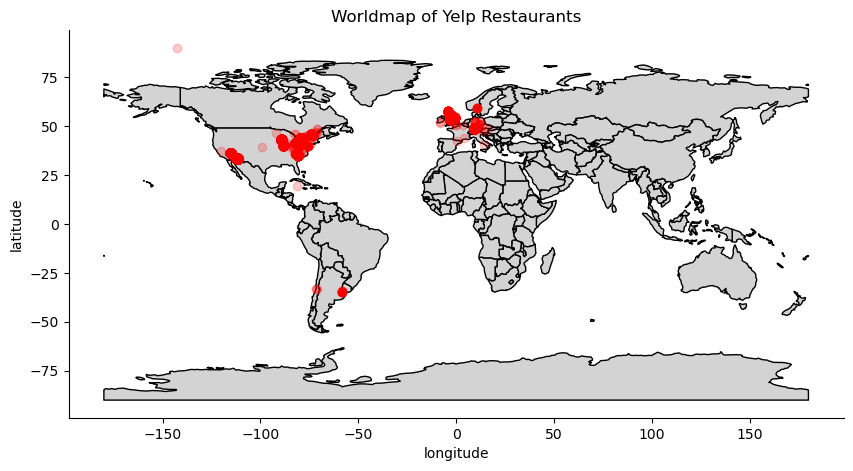

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

# plotting a worldmap
fig, gax = plt.subplots(figsize=(10,10))
world.plot(ax=gax, edgecolor='black',color='lightgrey')


# restaurants 
df2_business["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))
df2_business["coordinates"] = df2_business["coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df2_business, geometry="coordinates")

gdf.plot(ax=gax, color='red', alpha = 0.2)

# labeling the map
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
gax.set_title('Worldmap of Yelp Restaurants')

### Restaurants in Arizona

In [30]:
# get the state of Arizona
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")

# Arizona restaurant coordinates
df2_business["coordinates"] = list(zip(df2_business.longitude, df2_business.latitude))

df2_business["coordinates_point"] = df2_business["coordinates"].apply(Point)

df_states = df2_business.groupby('state')

# apply the selector to subset
df_arizona = df_states.get_group('AZ')

df_arizona = df_states.get_group('AZ')
plot = px.density_mapbox(df_arizona, lat='latitude', lon='longitude', z='stars', opacity=0.5, radius=6, title="Heatmap of Restaurant Ratings in Arizona", mapbox_style="open-street-map")
plot

## Merging With a New Data Set

Mergin the Yelp data with a dataset for the population density of the United States 

## Conclusion

From this extensive review on Yelp restaurants and their data, the attributes for location, category, and user interaction were analyzed to draw correlations with the rating a restaurant may receive. Location was analyzed at the state and city level. At the state level, the findings concluded that on average, states in the United States of America tend to have similar restaurant ratings of around 3.5 Yelp stars. This was lower than the only reported state outside of the United States, which was located in Canada reported an average restaurant rating of about 4.0 Yelp stars. This finding stands out because of this difference in restaurant ratings according to the country, however, it requires more elaborate data because more states outside of the United States should be included in this analysis to make conclusive findings. At the city level, the findings concluded that restaurants in cities located in North America tend to receive similar ratings. These ratings were, on average, lower than those of the reported restaurants in cities that were located in Europe. From this analysis, it can be concluded that there is some relation between the location of a restaurant and the rating it may receive, but the dataset lacked restaurants represented in locations outside of the Americas. The category a restaurant is associated with was also analyzed, and the findings illustrated how there may be a correlation between the types of food served and the expected restaurant rating. For example, the 'Fast Food' category received lower ratings, on average, and the 'Burger' category which can be associated with fast food, also received lower ratings, on average, than the other categories accounted for. This analysis leaves possible explanations for the quality of food served in restaurants which fall under these categories, or whether the critique for these categories is stronger. Lastly, user interaction and restaurant ratings were analyzed. The number of reviews a restaurant received reflected interesting findings where restaurants with fewer reviews were more likely to receive ratings around 3.5 Yelp stars. However, as restaurants received more reviews, analysis reflected that there were more fluctuations in the average reviews restaurants received. This may be due to the true quality of the restaurant being illustrated in the data, or there may not have been enough restaurants with that specific review count recorded, and the fluctuation points may be outliers due to not enough data collected. Lastly, the amount of Yelp check-ins a restaurant receives was analyzed alongside its average rating. The data reflected a skewness towards a higher rating of about 4.0 Yelp stars for restaurants with more reviews. This could be due to people being more willing to use the check-in feature when they are at a restaurant they consider good. 

Some limitations of the current analysis include a lack of data for certain attributes that were analyzed. For example, the restaurants reported were mainly based in North America, so it would be difficult to make more worldly conclusions of restaurant ratings in different countries. Additionally, more generalizing for summarizing data would possibly make the analysis more effective, especially when analyzing the number of reviews. These could have been grouped in multiples of 50s rather than the exact review value because then certain points would not be reflective of groups of restaurants, but rather only one restaurant.

Some future steps would be accounting for the limitations described, and further condensing the grouping of the data to form conclusions. Additionally, further analysis to explore the correlation between restaurant business hours and their ratings as well as how individual users tend to rate restaurants would be interesting in creating a more holistic picture of the factors which compose a Yelp restaurant review.

# Citations

Yelp, Inc. “Yelp Dataset.” Kaggle.com, 2018. https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/versions/6/code?select=yelp_business.csv.

‌
